# [LG 에너지 솔루션]
## DX Expert 양성과정 WEEK 2
## Convolutional Neural Network 2 - (1)

## 강의 복습
Convolutional Neural Network - Part 2

* ADENDA 02 Popular CNN Structures

* ADENDA 03 CAM & Grad-CAM

## 실습 요약
1. 본 실습에서는 사전학습된 CNN 모델을 활용하여 분류 문제를 풀이합니다.
2. 학습된 모델을 활용하여 평가를 진행합니다.
3. 학습된 모델에 GradCAM을 적용하여 예측에 가장 큰 영향을 미친 부분을 탐지해냅니다.


---

### STEP 0. 환경 구축하기
* 필요한 Library 들을 import 합니다

In [ ]:
# Data Analysis
import random
import pandas as pd
import numpy as np

import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Neural Network Model
%matplotlib inline
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Check torch version & device
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.11.0+cu102].
device:[cuda:0].


In [ ]:
# set random seed 

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
set_seed(42)

---

### STEP 1. 데이터 준비하기
금일 실습에서는 **casting product image data for quality inspection** 이미지 데이터를 활용합니다. 
* casting은 몰드에 liquid material을 부어 원하는 모양의 제품을 만들어내는 과정으로, 해당 과정에서 일정한 제품 shape를 유지하는것이 중요함 
* 정밀 검사 과정에서 생산 제품에 대해 Ok / Defect 결정을 내릴 수 있음
* 데이터셋 출처 
    : https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product

casting_data  
├───test  
│   ├───def_front  
│   └───ok_front  
└───train  
    ├───def_front  
    └───ok_front  

In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/yukyunglee/LG_ES_CNN_2

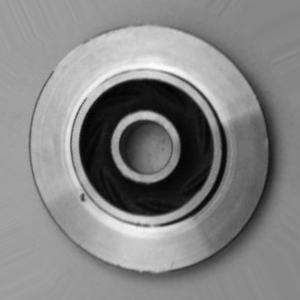

In [26]:
# defect 이미지 불러오기
img_path = os.path.join('./LG_ES_CNN_2/data/casting_data', "train/def_front/cast_def_0_0.jpeg")
def_img = Image.open(img_path)
def_img

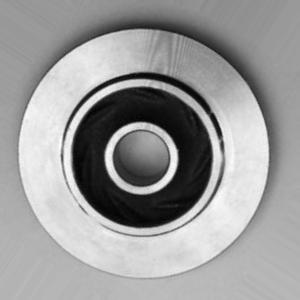

In [6]:
# ok 이미지 불러오기
img_path = os.path.join('./LG_ES_CNN_2/casting_data', "train/ok_front/cast_ok_0_1.jpeg")
def_img = Image.open(img_path)
def_img

### STEP 2. 전처리 진행 (Preprocessing)

In [27]:
# 데이터 전처리
# 이미지 형태의 데이터를 숫자값으로 변경하고, 적절한 Normalization을 진행합니다.

transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### STEP 3. Pytorch Dataset 정의하기
* 딥러닝 프레임워크를 활용하여 학습하기위해서는 물리적인 데이터셋을 학습 가능한 형태로 바꾸어주어야 합니다
* Pytorch에서는 Dataset이라는 class를 상속받아 해당 값을 정의내릴 수 있습니다

In [28]:
class CastingDataset(Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = path
        # 이미지의 경로를 맞추어 학습데이터/평가데이터를 불러올 수 있도록 준비합니다
        if train:
            self.def_path = path + "/train/def_front"
            self.ok_path = path + "/train/ok_front"
        else:
            self.def_path = path + "/test/def_front"
            self.ok_path = path + "/test/ok_front"
        # 해당 경로에 있는 모든 데이터를 가져오며 jpeg 확장자인 모든 파일을 사용합니다
        # glob라는 라이브러리를 통해 모든 이미지를 list형태로 불러올 수 있게됩니다
        self.def_img_list = glob.glob(self.def_path + "/*.jpeg")
        self.ok_img_list = glob.glob(self.ok_path + "/*.jpeg")

        # 미리 선언해두었던 전처리 프로세스를 불러옵니다
        self.transform = transform
        # defect, ok 이미지를 모두 합쳐 전체 이미지 데이터를 구성합니다
        self.img_list = self.def_img_list + self.ok_img_list

        # 이미지별 학습 라벨(label)을 부착합니다
        # defect : 0 / ok : 1
        self.class_list = [0] * len(self.def_img_list) + [1] * len(self.ok_img_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        label = self.class_list[idx]
        img = Image.open(img_path)

        # 선언되었던 전처리를 이미지에 적용하는 과정
        if self.transform is not None:
            img = self.transform(img)

        # CastingDataset은 image와 label을 하나의 세트로 리턴하게 됩니다
        return img, label

### STEP 4. 모델 정의 및 학습 준비하기
* pretrained CNN 모델인 ResNet을 활용하여 분류 문제 풀이를 준비합니다
* 미리 학습된 가중치를 load하는 방법과 학습 모델을 수정하는 방법을 숙지하면 됩니다

In [29]:
# Parameter setting
NUM_CLASS = 2

BATCH = 50
EPOCH = 10
LR = 0.0001

LOGGING = 10


In [30]:
# Dataset을 정의
train_dataset = CastingDataset(
    path="./LG_ES_CNN_2/data/casting_data", train=True, transform=transformations
)
test_dataset = CastingDataset(
    path="./LG_ES_CNN_2/data/casting_data", train=False, transform=transformations
)
# mini-batch로 나누어 학습가능한 형태로 변환
# Dataloader라 부름
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=BATCH, shuffle=True, drop_last=False
)
test_dataloader = DataLoader(
    dataset=train_dataset, batch_size=BATCH, shuffle=True, drop_last=False
)


In [31]:
# 모델 정의하기 

model = models.resnet18(pretrained=True)
# model = models.AlexNet(pretrained=True)
num_ftrs = model.fc.in_features

# 데이터에 맞게 output layer 수정하기
model.fc = nn.Linear(num_ftrs, NUM_CLASS)
model.fc = model.fc.cuda() if model else model.fc

model = model.cuda()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /home/yukyung/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
# 학습에 필요한 목적함수를 설정하고, 모델 업데이트를 위해 optimizer를 세팅합니다.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()


In [ ]:
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, EPOCH + 1):
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"Epoch {epoch}\n")
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()

        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred == target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print(
                "Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(
                    epoch, EPOCH, batch_idx, total_step, loss.item()
                )
            )
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss / total_step)
    print(
        f"\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}"
    )
    batch_loss = 0
    total_t = 0
    correct_t = 0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in test_dataloader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t == target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss / len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(
            f"validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n"
        )

        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), "resnet.pt")
            print("Improvement-Detected, save-model")
    model.train()

Epoch 1

Epoch [1/10], Step [0/133], Loss: 0.7248
Epoch [1/10], Step [20/133], Loss: 0.5746
Epoch [1/10], Step [40/133], Loss: 0.4641
Epoch [1/10], Step [60/133], Loss: 0.3533
Epoch [1/10], Step [80/133], Loss: 0.2956
Epoch [1/10], Step [100/133], Loss: 0.2936
Epoch [1/10], Step [120/133], Loss: 0.2241

train-loss: 0.4046, train-acc: 85.3008
validation loss: 0.2265, validation acc: 96.1405

Improvement-Detected, save-model
Epoch 2

Epoch [2/10], Step [0/133], Loss: 0.1935
Epoch [2/10], Step [20/133], Loss: 0.2491
Epoch [2/10], Step [40/133], Loss: 0.2138
Epoch [2/10], Step [60/133], Loss: 0.1541
Epoch [2/10], Step [80/133], Loss: 0.1177
Epoch [2/10], Step [100/133], Loss: 0.1604
Epoch [2/10], Step [120/133], Loss: 0.1658

train-loss: 0.2867, train-acc: 97.4974
validation loss: 0.1690, validation acc: 98.5527

Improvement-Detected, save-model
Epoch 3

Epoch [3/10], Step [0/133], Loss: 0.1186
Epoch [3/10], Step [20/133], Loss: 0.1138
Epoch [3/10], Step [40/133], Loss: 0.1068
Epoch [3/10]

### STEP 5. 성능 확인하기

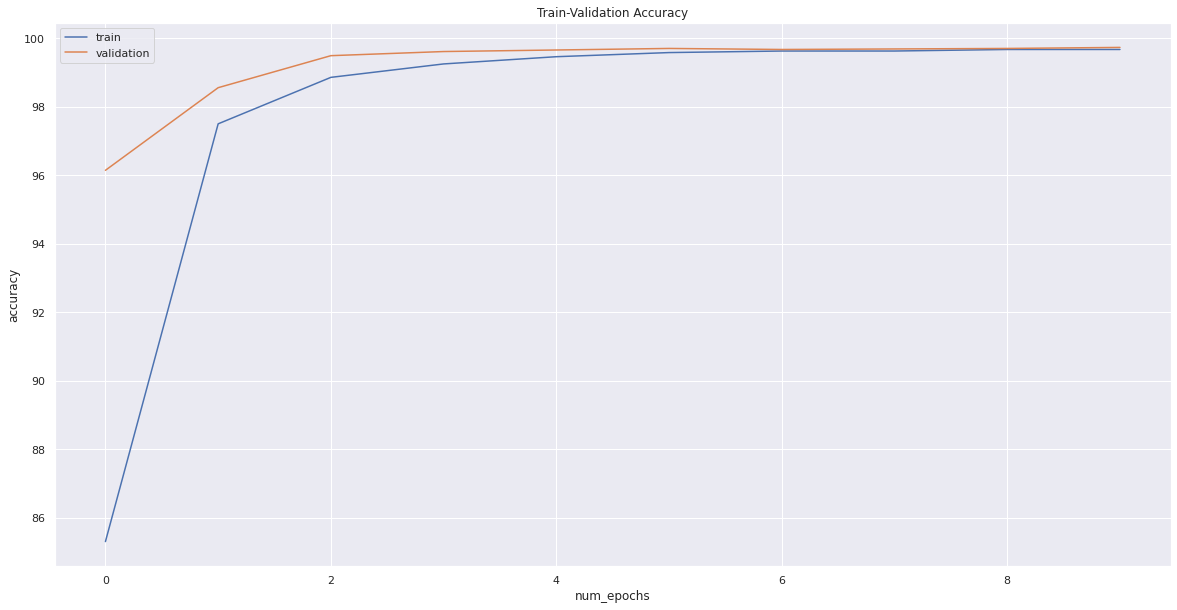

In [14]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

### STEP 6 : Grad Cam을 활용하여 예측 모델로 부터 중요한 지점 찾기

In [15]:
! pip install pytorch-gradcam

In [16]:
# 모듈 불러오기
import os
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from PIL import Image

from torchvision.utils import make_grid

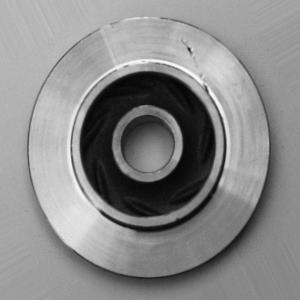

In [17]:
# test 이미지 불러오기
img_path = os.path.join('./data/casting_data', "test/def_front/cast_def_0_7.jpeg")
pil_img = Image.open(img_path)
pil_img

In [18]:
# test 이미지 크기 변환
torch_img = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])(pil_img).to(device)

In [19]:
# test 이미지 정규화
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
normed_torch_img.shape

torch.Size([1, 3, 224, 224])

In [20]:
# 모든 layer에서 gradient 계산 가능하도록 설정
for param in model.parameters():
    param.requires_grad = True

In [21]:
# Grad-CAM 모델 구축
# target layer는 마지막 layer로 설정함
model.eval()

target_layer = model.layer4
gradcam = GradCAM(model, target_layer)

In [22]:
# GradCAM salinecy map 도출
mask, _ = gradcam(normed_torch_img)
heatmap, result = visualize_cam(mask, torch_img)

/home/yukyung/anaconda3/envs/oh/lib/python3.7/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/yukyung/anaconda3/envs/oh/lib/python3.7/site-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


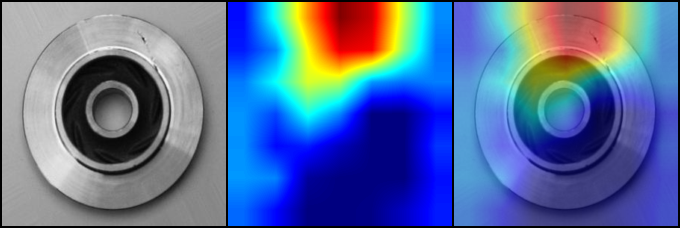

In [23]:
# 결과 시각화
# 벌이 있는 위치의 activation이 큰 것을 통해 모델이 해당 부분을 기반으로 이미지를 'bees'로 분류했다고 해석할 수 있음
images = [torch_img.cpu(), heatmap, result]
grid_image = make_grid(images, ncol=1)

transforms.ToPILImage()(grid_image)